### An exploration of the Centers for Disease Control (CDC) Social Vulnerability Index (SVI) dataset

**Social vulnerability** refers to the resilience of communities when confronted by external stressors, such as:
<ul>
    <li>natural disasters</li>
    <li>human caused diasters</li>
    <li>disease outbreaks</li>
</ul>

**Socially vulnerable populations** are those who have special needs, including, but not limited to:
<ul>
    <li>people without vehicles</li>
    <li>people with disabilities</li>
    <li>older adults</li>
    <li>people with limited English proficiency</li>
</ul>

Recognizing a need to quantify this information, the United States **Centers for Disease Control** (CDC) produced the **Social Vulnerability Index** (SVI). More information about this resource can be found at the [at a glance page for the CDC SVI](https://www.atsdr.cdc.gov/placeandhealth/svi/at-a-glance_svi.html).

This notebook will serve as a basic introduction to the dataset and identify some simple use cases. The first step is to [download the spreadsheet file from the website](https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import geodatasets

The first step is to load the downloaded spreadsheet. We will use Pandas to load the dataset and later merge with GeoPandas.

In [11]:
# Load the CDC SVI dataset for 2018
sci = pd.read_csv("./data/cdcsvi/svi_interactive_map2018.csv")

# -999 is a missing value
sci = sci.replace(-999, np.nan)

Load the census tract shapefiles from the Census.

Text(192.00271940630495, 0.5, 'Latitude')

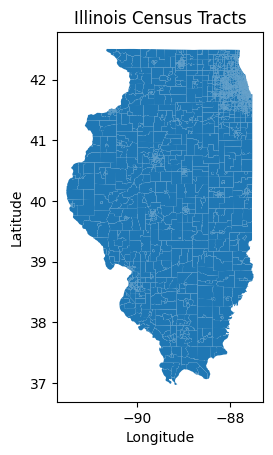

In [13]:
census = geopandas.read_file("./data/chicago/census2018/tl_2018_17_tract.zip!tl_2018_17_tract.shp")
census = census.rename(columns = {"GEOID": "FIPS"})
census['FIPS'] = census['FIPS'].astype(int)

# Combine the map and dataframe
census = census.merge(sci, on = "FIPS")

# Plot Chicago census tracts
census.plot()
plt.title("Illinois Census Tracts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

The CDC SVI dataset contains many features. Explanations for each of the features can be found in the documentation for the SVI database.

In [14]:
print(sci.columns)

Index(['GEO LEVEL', 'GEO COMPARISON', 'Year', 'GEO UNIT', 'ST', 'STATE',
       'ST_ABBR', 'STCNTY', 'COUNTY', 'FIPS',
       ...
       'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL', 'E_UNINSUR',
       'M_UNINSUR', 'EP_UNINSUR', 'MP_UNINSUR', 'E_DAYPOP'],
      dtype='object', length=124)


Let's focus on Chicago. We will call the Chicago community map from the GeoPandas library.

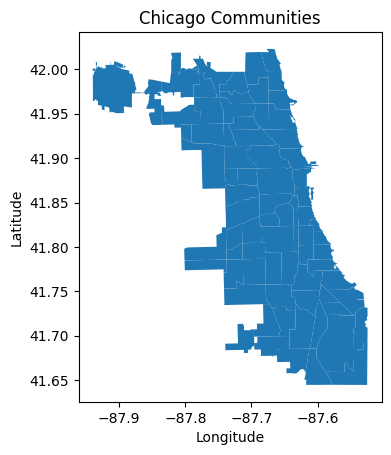

In [15]:
# Reproject and spatial join for Chicago communities
chicago = geopandas.read_file(geodatasets.get_path("geoda.chicago_commpop"))

chicago.plot();
plt.title("Chicago Communities")
plt.xlabel("Longitude");
plt.ylabel("Latitude");

Now we want to dissolve the Chicago communities and Census tracts together. Plotting each of Census tracts in the Chicago area will be quite overwhelming, as seen from our prior plots. Therefore, we take a higher level approach.

''

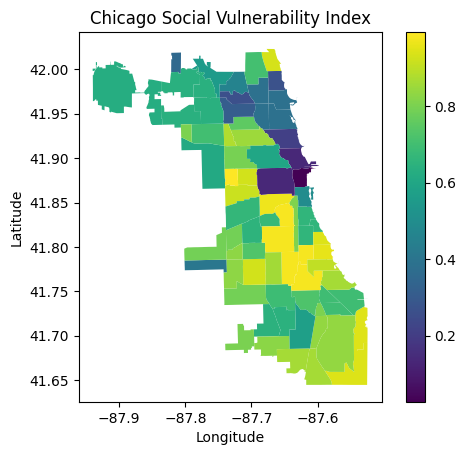

In [16]:
combined = chicago.sjoin(census.to_crs(epsg=4326), how = 'inner')

combined = combined.dissolve(by='community')

# Remove sjoin geopandas names then join with nodes
combined = combined.drop(['index_right'], axis=1)

base = combined.plot(column = 'RPL_THEMES', 
              legend = True,
              missing_kwds={
                  "color": 'lightgrey',
                  "edgecolor": 'red',
                  "hatch": "///",
                  "label": "Missing Values"
              },
              zorder = 1,
              )
plt.title("Chicago Social Vulnerability Index")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
;

''

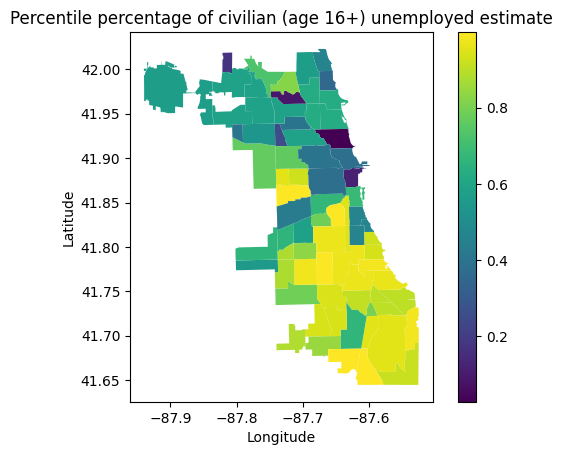

In [17]:
base = combined.plot(column = 'EPL_UNEMP', 
              legend = True,
              missing_kwds={
                  "color": 'lightgrey',
                  "edgecolor": 'red',
                  "hatch": "///",
                  "label": "Missing Values"
              },
              zorder = 1,
              )
plt.title("Percentile percentage of civilian (age 16+) unemployed estimate")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
;

''

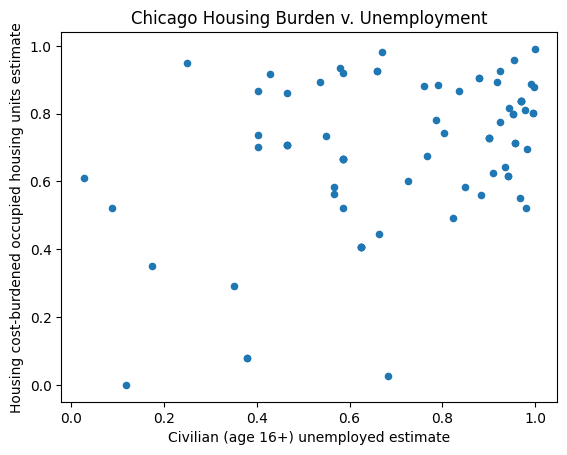

In [18]:
combined.plot(kind="scatter", x="EPL_UNEMP", y="EPL_NOHSDP")
plt.title("Chicago Housing Burden v. Unemployment")
plt.xlabel("Civilian (age 16+) unemployed estimate")
plt.ylabel("Housing cost-burdened occupied housing units estimate")
;

''

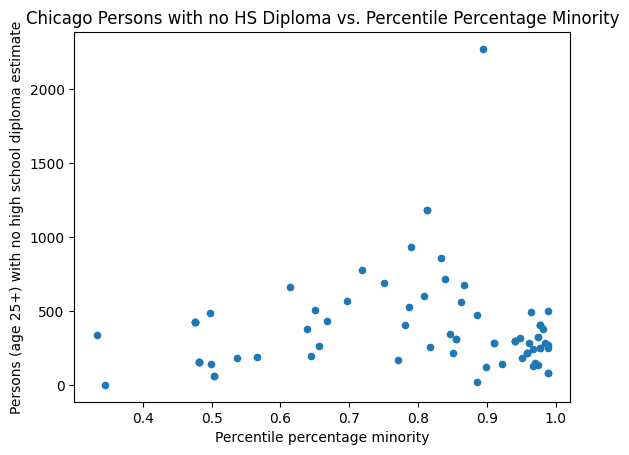

In [19]:
combined.plot(kind="scatter", x="EPL_MINRTY", y="E_NOHSDP")
plt.title("Chicago Persons with no HS Diploma vs. Percentile Percentage Minority")
plt.xlabel("Percentile percentage minority")
plt.ylabel("Persons (age 25+) with no high school diploma estimate")
;

Now that we can visualize the CDC SVI dataset for the Chicago urban area, we want to do further analysis with another dataset. Perhaps we want to examine the distribution of Chicago Urban Array data across the city.

''

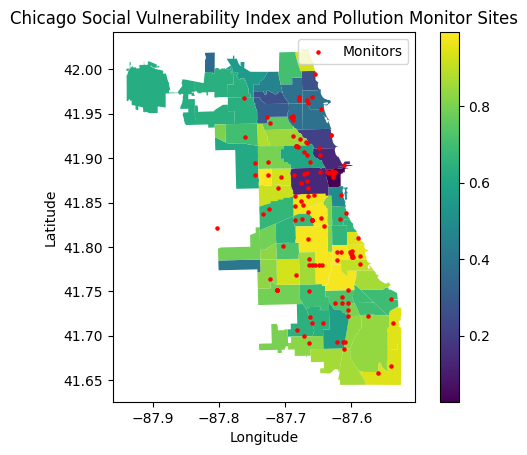

In [20]:
nodes = pd.read_csv("./data/aot/nodes.csv")

# Convert lat and lon to geopandas
nodes = geopandas.GeoDataFrame(nodes, 
                               geometry = geopandas.points_from_xy(nodes.lon, nodes.lat), 
                               crs = "EPSG:4326"
                               )

base = nodes.plot(color = "red", zorder = 2, 
                  markersize = 5, 
                  label = 'Monitors')

combined.plot(ax = base,
              column = 'RPL_THEMES', 
              legend = True,
              missing_kwds={
                  "color": 'lightgrey',
                  "edgecolor": 'red',
                  "hatch": "///",
                  "label": "Missing Values"
              },
              zorder = 1,
              )

plt.title("Chicago Social Vulnerability Index and Pollution Monitor Sites")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
;